In [8]:
# Importing the necessary libraries

import tensorflow as tf
import albumentations as albu
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score
from ModelArchitecture.DiceLoss import dice_metric_loss
from ModelArchitecture import Unet
from ImageLoader import ImageLoader2D

In [9]:
# Checking the number of GPUs available

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
# Setting the model parameters

img_size = 352
dataset_type = 'kvasir' # Options: kvasir/cvc-clinicdb/cvc-colondb/etis-laribpolypdb
learning_rate = 1e-4
seed_value = 58800
filters = 17 # Number of filters, the paper presents the results with 17 and 34
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

current_datetime = datetime.datetime.now()
ct = "_".join([str(current_datetime.year), str(current_datetime.month), str(current_datetime.day), str(current_datetime.hour), str(current_datetime.minute), str(current_datetime.second)])

model_type = "Unet"

progress_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) +  '_' + str(ct) + '.csv'
progressfull_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.txt'
plot_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.png'
model_path = 'ModelSaveTensorFlow/' + model_type + '_filters_' + str(filters) + '_' + str(ct)

EPOCHS = 600
min_loss_for_saving = 0.9

In [11]:
# Loading the data

X, Y = ImageLoader2D.load_data(img_size, img_size, -1, 'kvasir')

Resizing training images and masks: 40


40it [00:05,  7.47it/s]


In [12]:
# Splitting the data, seed for reproducibility

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle= True, random_state = seed_value)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle= True, random_state = seed_value)

In [13]:
# Defining the augmentations

aug_train = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
    albu.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), always_apply=True),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        ug = aug_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(ug['image'])  
        y_train_out.append(ug['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [14]:
# Creating the model

model = Unet.create_model(img_height=img_size, img_width=img_size, input_channels=3, out_classes=1, starting_filters=filters)

Starting UNet


In [15]:
# Compiling the model

model.compile(optimizer=optimizer, loss=dice_metric_loss)

In [16]:
# Training the model

step = 0

for epoch in range(0, EPOCHS):
    
    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
        
    image_augmented, mask_augmented = augment_images()
    
    csv_logger = CSVLogger(progress_path, append=True, separator=';')
    
    model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=4, validation_data=(x_valid, y_valid), verbose=1, callbacks=[csv_logger])
    
    prediction_valid = model.predict(x_valid, verbose=0)
    loss_valid = dice_metric_loss(y_valid, prediction_valid)
    
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))
        
    prediction_test = model.predict(x_test, verbose=0)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))
        
    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')
    
    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        model.save(model_path)
        
    del image_augmented
    del mask_augmented

    gc.collect()

Training, epoch 0
Learning Rate: 0.0001
8/8 [==============================] - 9s 148ms/step - loss: 0.8077 - val_loss: 0.8164
Loss Validation: 0.8163837
Loss Test: 0.78263444
Saved model with val_loss:  0.8163837


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


Training, epoch 1
Learning Rate: 0.0001
8/8 [==============================] - 1s 109ms/step - loss: 0.7623 - val_loss: 0.8138
Loss Validation: 0.813812
Loss Test: 0.78105223
Saved model with val_loss:  0.813812


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


Training, epoch 2
Learning Rate: 0.0001
8/8 [==============================] - 1s 110ms/step - loss: 0.7071 - val_loss: 0.8080
Loss Validation: 0.80796695
Loss Test: 0.7738229
Saved model with val_loss:  0.80796695


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


Training, epoch 3
Learning Rate: 0.0001
8/8 [==============================] - 1s 108ms/step - loss: 0.6836 - val_loss: 0.8055
Loss Validation: 0.8055294
Loss Test: 0.76908976
Saved model with val_loss:  0.8055294


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


Training, epoch 4
Learning Rate: 0.0001
8/8 [==============================] - 1s 111ms/step - loss: 0.6719 - val_loss: 0.8055
Loss Validation: 0.8055088
Loss Test: 0.7662788
Saved model with val_loss:  0.8055088


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


Training, epoch 5
Learning Rate: 0.0001
8/8 [==============================] - 1s 107ms/step - loss: 0.6819 - val_loss: 0.8144
Loss Validation: 0.81435937
Loss Test: 0.7707201
Training, epoch 6
Learning Rate: 0.0001
8/8 [==============================] - 1s 112ms/step - loss: 0.6486 - val_loss: 0.8145
Loss Validation: 0.81452864
Loss Test: 0.7632048
Training, epoch 7
Learning Rate: 0.0001
8/8 [==============================] - 1s 106ms/step - loss: 0.6171 - val_loss: 0.8127
Loss Validation: 0.8126763
Loss Test: 0.74239814
Training, epoch 8
Learning Rate: 0.0001
8/8 [==============================] - 1s 111ms/step - loss: 0.6161 - val_loss: 0.8235
Loss Validation: 0.8235475
Loss Test: 0.75708234
Training, epoch 9
Learning Rate: 0.0001
8/8 [==============================] - 1s 111ms/step - loss: 0.6155 - val_loss: 0.8307
Loss Validation: 0.8306617
Loss Test: 0.7714062
Training, epoch 10
Learning Rate: 0.0001
8/8 [==============================] - 1s 112ms/step - loss: 0.6113 - val_loss: 

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


Training, epoch 16
Learning Rate: 0.0001
8/8 [==============================] - 1s 107ms/step - loss: 0.5932 - val_loss: 0.8339
Loss Validation: 0.8338735
Loss Test: 0.810409
Training, epoch 17
Learning Rate: 0.0001
8/8 [==============================] - 1s 116ms/step - loss: 0.5591 - val_loss: 0.8742
Loss Validation: 0.87424135
Loss Test: 0.8595016
Training, epoch 18
Learning Rate: 0.0001
8/8 [==============================] - 1s 109ms/step - loss: 0.5606 - val_loss: 0.8619
Loss Validation: 0.86186045
Loss Test: 0.7823627
Training, epoch 19
Learning Rate: 0.0001
8/8 [==============================] - 1s 114ms/step - loss: 0.5550 - val_loss: 0.8690
Loss Validation: 0.86901104
Loss Test: 0.7204229
Training, epoch 20
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.5594 - val_loss: 0.8640
Loss Validation: 0.8639731
Loss Test: 0.68647665
Training, epoch 21
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.5477 - val_lo

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


Training, epoch 23
Learning Rate: 0.0001
8/8 [==============================] - 1s 116ms/step - loss: 0.5418 - val_loss: 0.6202
Loss Validation: 0.6201525
Loss Test: 0.46650523
Saved model with val_loss:  0.6201525


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


Training, epoch 24
Learning Rate: 0.0001
8/8 [==============================] - 1s 109ms/step - loss: 0.5263 - val_loss: 0.6622
Loss Validation: 0.66224605
Loss Test: 0.4308225
Training, epoch 25
Learning Rate: 0.0001
8/8 [==============================] - 1s 109ms/step - loss: 0.5437 - val_loss: 0.7194
Loss Validation: 0.7193514
Loss Test: 0.46065378
Training, epoch 26
Learning Rate: 0.0001
8/8 [==============================] - 1s 111ms/step - loss: 0.5775 - val_loss: 0.5938
Loss Validation: 0.5937865
Loss Test: 0.37383854
Saved model with val_loss:  0.5937865


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


Training, epoch 27
Learning Rate: 0.0001
8/8 [==============================] - 1s 104ms/step - loss: 0.5148 - val_loss: 0.6122
Loss Validation: 0.6122105
Loss Test: 0.396792
Training, epoch 28
Learning Rate: 0.0001
8/8 [==============================] - 1s 112ms/step - loss: 0.5430 - val_loss: 0.5548
Loss Validation: 0.5547923
Loss Test: 0.39403874
Saved model with val_loss:  0.5547923


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


Training, epoch 29
Learning Rate: 0.0001
8/8 [==============================] - 1s 106ms/step - loss: 0.5421 - val_loss: 0.6960
Loss Validation: 0.69595647
Loss Test: 0.4101057
Training, epoch 30
Learning Rate: 0.0001
8/8 [==============================] - 1s 118ms/step - loss: 0.5397 - val_loss: 0.5485
Loss Validation: 0.5485429
Loss Test: 0.38327777
Saved model with val_loss:  0.5485429


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


Training, epoch 31
Learning Rate: 0.0001
8/8 [==============================] - 1s 110ms/step - loss: 0.5460 - val_loss: 0.5834
Loss Validation: 0.5833983
Loss Test: 0.44763666
Training, epoch 32
Learning Rate: 0.0001
8/8 [==============================] - 1s 107ms/step - loss: 0.5109 - val_loss: 0.6583
Loss Validation: 0.658344
Loss Test: 0.3294869
Training, epoch 33
Learning Rate: 0.0001
8/8 [==============================] - 1s 117ms/step - loss: 0.5394 - val_loss: 0.5373
Loss Validation: 0.5372516
Loss Test: 0.35763812
Saved model with val_loss:  0.5372516


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


Training, epoch 34
Learning Rate: 0.0001
8/8 [==============================] - 1s 110ms/step - loss: 0.5297 - val_loss: 0.6083
Loss Validation: 0.6083008
Loss Test: 0.33446425
Training, epoch 35
Learning Rate: 0.0001
8/8 [==============================] - 1s 110ms/step - loss: 0.5079 - val_loss: 0.6630
Loss Validation: 0.6630373
Loss Test: 0.36224204
Training, epoch 36
Learning Rate: 0.0001
8/8 [==============================] - 1s 111ms/step - loss: 0.5162 - val_loss: 0.6139
Loss Validation: 0.61390066
Loss Test: 0.34377676
Training, epoch 37
Learning Rate: 0.0001
8/8 [==============================] - 1s 115ms/step - loss: 0.5218 - val_loss: 0.5659
Loss Validation: 0.56589735
Loss Test: 0.36008692
Training, epoch 38
Learning Rate: 0.0001
8/8 [==============================] - 1s 112ms/step - loss: 0.5141 - val_loss: 0.5525
Loss Validation: 0.5524674
Loss Test: 0.33688343
Training, epoch 39
Learning Rate: 0.0001
8/8 [==============================] - 1s 112ms/step - loss: 0.5280 - va

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


Training, epoch 44
Learning Rate: 0.0001
8/8 [==============================] - 1s 114ms/step - loss: 0.5126 - val_loss: 0.5372
Loss Validation: 0.5372158
Loss Test: 0.34246725
Training, epoch 45
Learning Rate: 0.0001
8/8 [==============================] - 1s 113ms/step - loss: 0.5262 - val_loss: 0.5284
Loss Validation: 0.52843755
Loss Test: 0.36604524
Saved model with val_loss:  0.52843755


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


Training, epoch 46
Learning Rate: 0.0001
8/8 [==============================] - 1s 105ms/step - loss: 0.5083 - val_loss: 0.5375
Loss Validation: 0.5375212
Loss Test: 0.29877186
Training, epoch 47
Learning Rate: 0.0001
8/8 [==============================] - 1s 114ms/step - loss: 0.5163 - val_loss: 0.5183
Loss Validation: 0.5183109
Loss Test: 0.38819098
Saved model with val_loss:  0.5183109


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


Training, epoch 48
Learning Rate: 0.0001
8/8 [==============================] - 1s 115ms/step - loss: 0.4822 - val_loss: 0.4871
Loss Validation: 0.4871201
Loss Test: 0.3715014
Saved model with val_loss:  0.4871201


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


Training, epoch 49
Learning Rate: 0.0001
8/8 [==============================] - 1s 112ms/step - loss: 0.4952 - val_loss: 0.4929
Loss Validation: 0.4928888
Loss Test: 0.3362018
Training, epoch 50
Learning Rate: 0.0001
8/8 [==============================] - 1s 112ms/step - loss: 0.4862 - val_loss: 0.5256
Loss Validation: 0.5256101
Loss Test: 0.36035568
Training, epoch 51
Learning Rate: 0.0001
8/8 [==============================] - 1s 107ms/step - loss: 0.4770 - val_loss: 0.6717
Loss Validation: 0.67173284
Loss Test: 0.30696642
Training, epoch 52
Learning Rate: 0.0001
8/8 [==============================] - 1s 107ms/step - loss: 0.4810 - val_loss: 0.6621
Loss Validation: 0.6621095
Loss Test: 0.31420654
Training, epoch 53
Learning Rate: 0.0001
8/8 [==============================] - 1s 111ms/step - loss: 0.5055 - val_loss: 0.6965
Loss Validation: 0.6965002
Loss Test: 0.35916752
Training, epoch 54
Learning Rate: 0.0001
8/8 [==============================] - 1s 111ms/step - loss: 0.5217 - val_

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/Unet_filters_17_2023_9_18_23_16_16\assets


Training, epoch 62
Learning Rate: 0.0001
8/8 [==============================] - 1s 108ms/step - loss: 0.4780 - val_loss: 0.5279
Loss Validation: 0.5279209
Loss Test: 0.28276324
Training, epoch 63
Learning Rate: 0.0001
8/8 [==============================] - 1s 111ms/step - loss: 0.4562 - val_loss: 0.6544
Loss Validation: 0.6544225
Loss Test: 0.28987926
Training, epoch 64
Learning Rate: 0.0001
8/8 [==============================] - 1s 110ms/step - loss: 0.4844 - val_loss: 0.4830
Loss Validation: 0.48299724
Loss Test: 0.29513532
Saved model with val_loss:  0.48299724


Loading the model
1/1 [==============================] - 0s 140ms/step


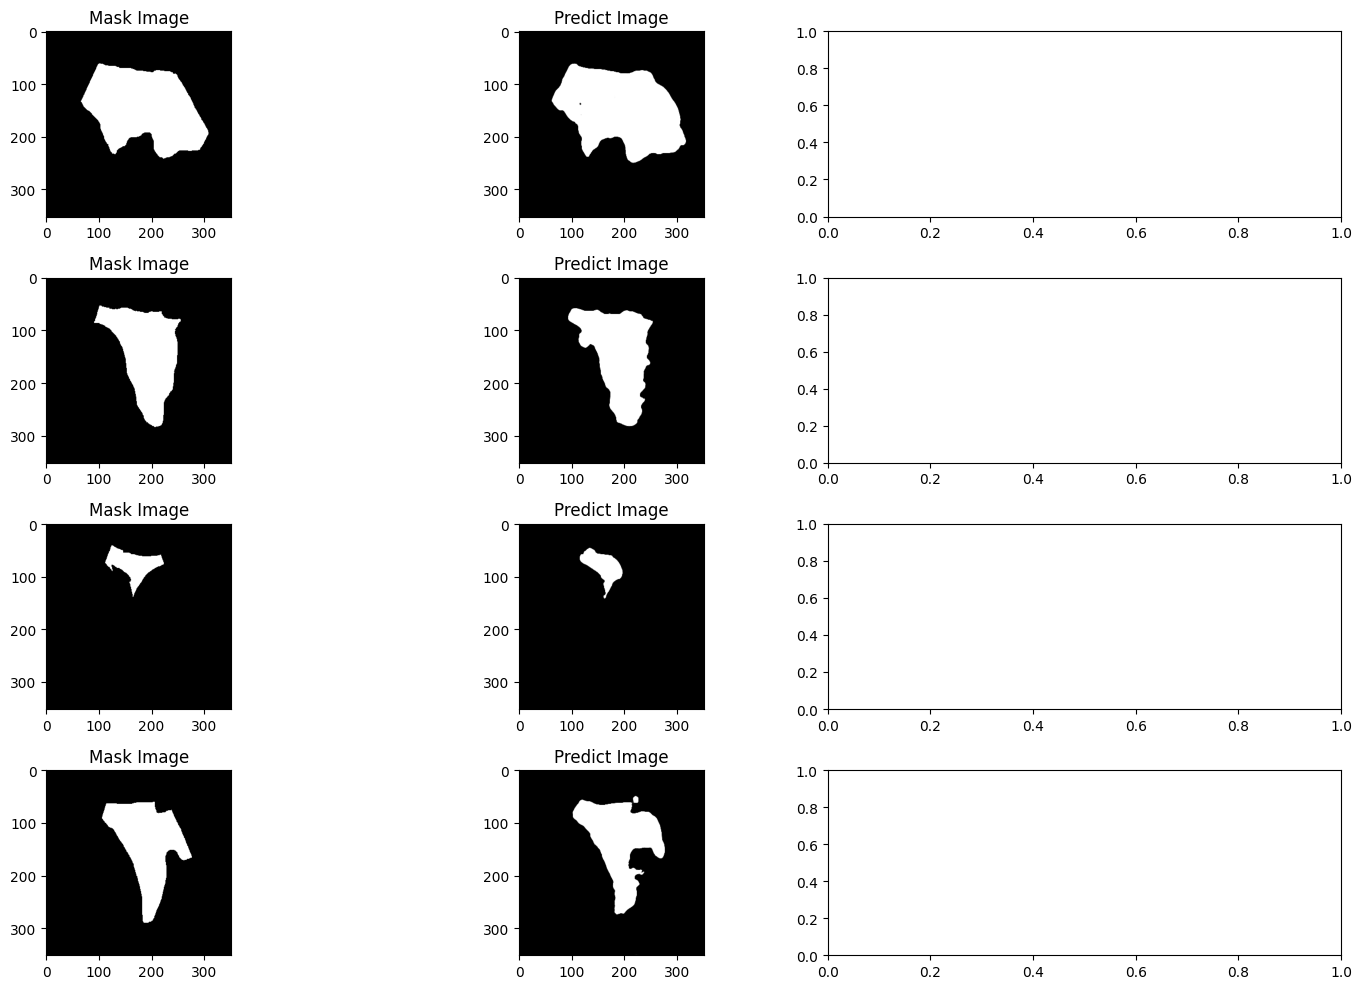

Predictions done
Dice finished
Miou finished
Precision finished
Recall finished
Accuracy finished
results_DuckNet_17_kvasir.txt
File done


In [ ]:
# Computing the metrics and saving the results

print("Loading the model")

model = tf.keras.models.load_model(model_path, custom_objects={'dice_metric_loss':dice_metric_loss})

prediction_train = model.predict(x_train, batch_size=4)
prediction_valid = model.predict(x_valid, batch_size=4)
prediction_test = model.predict(x_test, batch_size=4)

fig, axs = plt.subplots(4, 3, figsize=(15, 10))

for i in range(len(prediction_test)):
    origin = x_test[i]
    origin = origin.squeeze()
    axs[i, 0].imshow(origin, cmap='gray') 
    axs[i, 0].set_title('Origin Image')

    mask = y_test[i]
    mask = mask.squeeze()
    axs[i, 1].imshow(mask, cmap='gray') 
    axs[i, 1].set_title('Mask Image')
    
    pred = prediction_test[i]
    pred = pred.squeeze()
    axs[i, 2].imshow(pred, cmap='gray')
    axs[i, 2].set_title('Predict Image')

plt.tight_layout()
plt.show()

print("Predictions done")

dice_train = f1_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
dice_test = f1_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
dice_valid = f1_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Dice finished")


miou_train = jaccard_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
miou_test = jaccard_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
miou_valid = jaccard_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Miou finished")


precision_train = precision_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                  np.ndarray.flatten(prediction_train > 0.5))
precision_test = precision_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                                 np.ndarray.flatten(prediction_test > 0.5))
precision_valid = precision_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                  np.ndarray.flatten(prediction_valid > 0.5))

print("Precision finished")


recall_train = recall_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                            np.ndarray.flatten(prediction_train > 0.5))
recall_test = recall_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                           np.ndarray.flatten(prediction_test > 0.5))
recall_valid = recall_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                            np.ndarray.flatten(prediction_valid > 0.5))

print("Recall finished")


accuracy_train = accuracy_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                np.ndarray.flatten(prediction_train > 0.5))
accuracy_test = accuracy_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                               np.ndarray.flatten(prediction_test > 0.5))
accuracy_valid = accuracy_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                np.ndarray.flatten(prediction_valid > 0.5))


print("Accuracy finished")


final_file = 'results_' + model_type + '_' + str(filters) + '_' + dataset_type + '.txt'
print(final_file)

with open(final_file, 'a') as f:
    f.write(dataset_type + '\n\n')
    f.write('dice_train: ' + str(dice_train) + ' dice_valid: ' + str(dice_valid) + ' dice_test: ' + str(dice_test) + '\n\n')
    f.write('miou_train: ' + str(miou_train) + ' miou_valid: ' + str(miou_valid) + ' miou_test: ' + str(miou_test) + '\n\n')
    f.write('precision_train: ' + str(precision_train) + ' precision_valid: ' + str(precision_valid) + ' precision_test: ' + str(precision_test) + '\n\n')
    f.write('recall_train: ' + str(recall_train) + ' recall_valid: ' + str(recall_valid) + ' recall_test: ' + str(recall_test) + '\n\n')
    f.write('accuracy_train: ' + str(accuracy_train) + ' accuracy_valid: ' + str(accuracy_valid) + ' accuracy_test: ' + str(accuracy_test) + '\n\n\n\n')

print('File done')